In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D

from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

2024-11-14 11:13:56.225336: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-14 11:14:29.754469: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
def ClassCNN(xTrain, yTrain, xVal, yVal, xTest, yTest,
                 learnRate=0.0001,
                 hiddenLayers=1,
                 layerWidth=64,
                 outputActivation="softmax",
                 hiddenActivation="relu",
                 convActivation="relu",
                 optimiser=keras.optimizers.SGD,
                 epochs=50,
                 alpha=5,
                 inputShape=(28, 28, 1),
                 outputShape=10,
                 lossFunction=keras.losses.SparseCategoricalCrossentropy(from_logits=True)):

  CNNModel = Sequential()
  CNNModel.add(Conv2D(32, (3, 3), activation=convActivation, input_shape=inputShape))
  CNNModel.add(MaxPooling2D((2, 2)))
  CNNModel.add(Conv2D(64, (3, 3), activation=convActivation))
  CNNModel.add(MaxPooling2D((2, 2)))
  CNNModel.add(Conv2D(128, (3, 3), activation=convActivation))
  CNNModel.add(MaxPooling2D((2, 2)))
  CNNModel.add(Conv2D(256, (3, 3), activation=convActivation))

  CNNModel.add(Flatten())

  for i in range(hiddenLayers):
    CNNModel.add(Dense(layerWidth, activation=hiddenActivation))

  CNNModel.add(Dense(outputShape, activation=outputActivation))

  CNNModel.compile(optimizer=optimiser(learning_rate=learnRate),
                loss=lossFunction,
                metrics=['accuracy'])

  #CNNModel.summary()
  history = CNNModel.fit(xTrain, yTrain, epochs=epochs,
                      validation_data=(xVal, yVal))
  
  print(history.history)

  pd.DataFrame(history.history).plot(figsize=(8, 5))
  plt.grid(True)
  plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
  plt.xlabel("Epochs")
  plt.show()

  val_loss, val_acc = CNNModel.evaluate(xVal,  yVal, verbose=2)
  test_loss, test_acc = CNNModel.evaluate(xTest,  yTest, verbose=2)

  print(f"Learning Rate: {learnRate}")
  print(f"Hidden layers: {hiddenLayers}")
  print(f"Layer Width: {layerWidth}")
  print(f"Optimiser: {optimiser}")
  print(f"Output Activation: {outputActivation}")
  print(f"Hidden Activation: {hiddenActivation}")
  print(f"Conv Activation: {convActivation}")
  print(f"Epochs: {epochs}")
  print(f"Validation loss: {val_loss}")
  print(f"Validation accuracy: {val_acc}")
  print(f"Test loss: {test_loss}")
  print(f"Test accuracy: {test_acc}")

  return test_acc, val_acc

24 Classes

In [ ]:
xSmallClock = np.load("data/75/images.npy")
ySmallClock = np.load("data/75/labels.npy")

ySmallClock = np.array([int(time[0] + (time[1] // 30)) for time in ySmallClock])  

xSmallClock = np.reshape(xSmallClock, (-1, 75, 75, 1))
xSmallClock = xSmallClock / 255.0

xTrain, xTest, yTrain, yTest = train_test_split(xSmallClock,
                                                ySmallClock,
                                                test_size=0.2)
xVal, xTest, yVal, yTest = train_test_split(xTest, yTest, test_size=0.5)

test_acc, val_acc = ClassCNN(xTrain, yTrain, xVal, yVal, xTest, yTest,
                                 learnRate=0.001,
                                hiddenLayers=2,
                                outputActivation="softmax",
                                hiddenActivation="relu",
                                convActivation="relu",
                                epochs=30,
                                optimiser=keras.optimizers.Adam,
                                inputShape=(75, 75, 1),
                                outputShape=24)

print(test_acc, val_acc)

720 Classes

Epoch 1/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 6.8069e-04 - loss: 6.5831 - val_accuracy: 0.0017 - val_loss: 6.5837
Epoch 2/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 9.0682e-04 - loss: 6.5805 - val_accuracy: 0.0000e+00 - val_loss: 6.5874
Epoch 3/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0019 - loss: 6.5796 - val_accuracy: 0.0000e+00 - val_loss: 6.5897
Epoch 4/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0015 - loss: 6.5782 - val_accuracy: 0.0011 - val_loss: 6.5915
Epoch 5/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0014 - loss: 6.5781 - val_accuracy: 0.0000e+00 - val_loss: 6.5938
Epoch 6/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0014 - loss: 6.5777 - val_accuracy: 0.0000e+00 - val_loss: 6.5958
Epoch 7/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0018 - loss: 6.5774 - val_accuracy: 0.0000e+00 - val_loss: 6.5967
Epoch 8/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.00

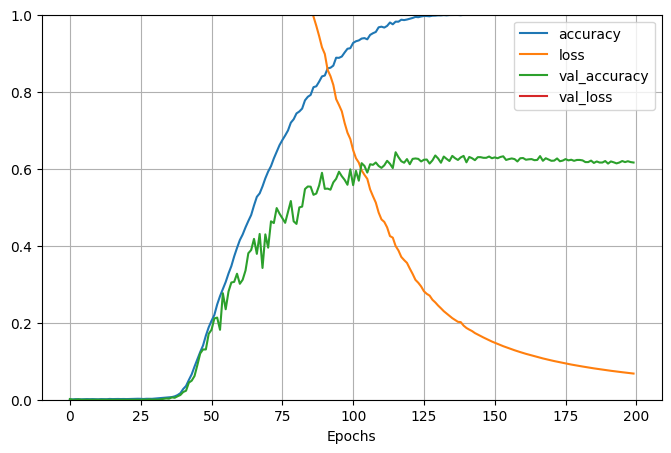

57/57 - 0s - 981us/step - accuracy: 0.6161 - loss: 1.2988
57/57 - 0s - 969us/step - accuracy: 0.6439 - loss: 1.2016
Learning Rate: 0.01
Hidden layers: 6
Layer Width: 346
Optimiser: <class 'keras.src.optimizers.adagrad.Adagrad'>
Output Activation: selu
Hidden Activation: softsign
Conv Activation: relu
Epochs: 200
Validation loss: 1.2987993955612183
Validation accuracy: 0.6161110997200012
Test loss: 1.201573371887207
Test accuracy: 0.6438888907432556
0.6438888907432556 0.6161110997200012


In [ ]:
xSmallClock = np.load("data/75/images.npy")
ySmallClock = np.load("data/75/labels.npy")

ySmallClock = np.array([int((time[0] * 60) + time[1]) for time in ySmallClock])  

xSmallClock = np.reshape(xSmallClock, (-1, 75, 75, 1))
xSmallClock = xSmallClock / 255.0

xTrain, xTest, yTrain, yTest = train_test_split(xSmallClock,
                                                ySmallClock,
                                                test_size=0.2)
xVal, xTest, yVal, yTest = train_test_split(xTest, yTest, test_size=0.5)

test_acc, val_acc = ClassCNN(xTrain, yTrain, xVal, yVal, xTest, yTest,
                         learnRate=0.01,
                         hiddenLayers=6,
                         layerWidth=346,
                         outputActivation="selu",
                         hiddenActivation="softsign",
                         convActivation="relu",
                         epochs=200,
                         optimiser=keras.optimizers.Adagrad,
                         inputShape=(75, 75, 1),
                         outputShape=720)

print(test_acc, val_acc)

150x150 pixel images

/vol/home/s4451856/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1731579377.845678   10779 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731579381.949522   10779 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731579381.9498

Epoch 1/200


I0000 00:00:1731579390.076684   10963 service.cc:146] XLA service 0x78b380010520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731579390.076702   10963 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-11-14 11:16:30.549804: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-14 11:16:31.273924: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  7/450 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.0000e+00 - loss: 6.5807  

I0000 00:00:1731579404.930696   10963 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


450/450 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 6.8212e-04 - loss: 6.5827 - val_accuracy: 5.5556e-04 - val_loss: 6.5839
Epoch 2/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.0011 - loss: 6.5803 - val_accuracy: 5.5556e-04 - val_loss: 6.5869
Epoch 3/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.0019 - loss: 6.5792 - val_accuracy: 5.5556e-04 - val_loss: 6.5913
Epoch 4/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.0013 - loss: 6.5783 - val_accuracy: 0.0017 - val_loss: 6.5904
Epoch 5/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.0016 - loss: 6.5783 - val_accuracy: 0.0000e+00 - val_loss: 6.5931
Epoch 6/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.0014 - loss: 6.5778 - val_accuracy: 0.0017 - val_loss: 6.5946
Epoch 7/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.0010 - loss: 6.5781 - val_accuracy: 5.5556e-04 - val_loss: 6.5959
Epoch 8/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.0013 - lo

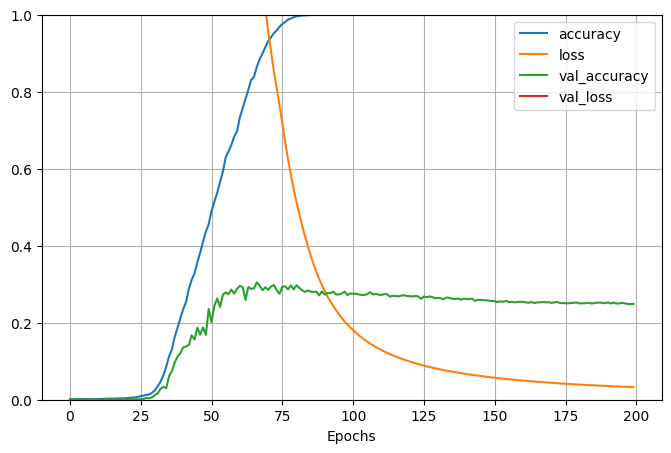

57/57 - 0s - 4ms/step - accuracy: 0.2489 - loss: 3.2734
57/57 - 0s - 4ms/step - accuracy: 0.2467 - loss: 3.3980
Learning Rate: 0.01
Hidden layers: 6
Layer Width: 346
Optimiser: <class 'keras.src.optimizers.adagrad.Adagrad'>
Output Activation: selu
Hidden Activation: softsign
Conv Activation: relu
Epochs: 200
Validation loss: 3.2734315395355225
Validation accuracy: 0.24888889491558075
Test loss: 3.3980140686035156
Test accuracy: 0.24666666984558105
0.24666666984558105 0.24888889491558075


In [6]:
xSmallClock = np.load("data/150/images.npy")
ySmallClock = np.load("data/150/labels.npy")

ySmallClock = np.array([int((time[0] * 60) + time[1]) for time in ySmallClock])  

xSmallClock = np.reshape(xSmallClock, (-1, 150, 150, 1))
xSmallClock = xSmallClock / 255.0

xTrain, xTest, yTrain, yTest = train_test_split(xSmallClock,
                                                ySmallClock,
                                                test_size=0.2)
xVal, xTest, yVal, yTest = train_test_split(xTest, yTest, test_size=0.5)

test_acc, val_acc = ClassCNN(xTrain, yTrain, xVal, yVal, xTest, yTest,
                         learnRate=0.01,
                         hiddenLayers=6,
                         layerWidth=346,
                         outputActivation="selu",
                         hiddenActivation="softsign",
                         convActivation="relu",
                         epochs=200,
                         optimiser=keras.optimizers.Adagrad,
                         inputShape=(150, 150, 1),
                         outputShape=720)

print(test_acc, val_acc)